In [1]:
%pylab inline
import numpy as np
import GPy
from matplotlib import pyplot as plt
import scipy.stats.stats 
from numpy import genfromtxt
from pandas import DataFrame, concat
import pandas as pd
from matplotlib.pyplot import *
from scipy.stats.stats import pearsonr as cor
from sklearn.preprocessing import scale
from pylab import pcolor, show, colorbar, xticks, yticks

Populating the interactive namespace from numpy and matplotlib


In [6]:
## Load the features
# load features and extract what we need
df_features_all   = pd.read_csv('./features_cho_processing/processed/features_genes0.csv',sep=' ')
#df_features_all   = df_features_all.drop('index',1)

# In principle we don't use the Codon context, so we only keep the rest of the features.
df_ids       = df_features_all.iloc[:,0:1] 
df_features1 = df_features_all.iloc[:,1:129] 
df_cc        = df_features_all.iloc[:,129:4225]
df_features2 = df_features_all.iloc[:,4225:]

df_features = concat([df_ids, df_features1,df_features2], axis=1)
df_features   = df_features.replace([np.inf, -np.inf], np.nan)
df_features   = df_features.dropna(0)

In [7]:
## load and merge the datasets that we need for the model
# load translation rates
df_data      = pd.read_csv('./data_cho/data_cleaned.csv', sep='\t').dropna()

In [40]:
# merge of the datasets
df_full       = pd.merge(df_data,df_features,  on='gene_ID', how='inner')

In [41]:
df_full

,gene_ID,protein,rna,protein_degradation,rna_hl,translation,aaa,aac,aag,aat,...,best_randomized_sec_structure40_5utr,best_local_sec_structure60_5utr,best_normalized_sec_structure60_5utr,best_randomized_sec_structure60_5utr,TOP_iniatiation_5utr,TOP_elongation_5utr,TOP_rnabinding_5utr,TOP_ribosomal_proteins,AREs_5utr,gc_content_total
0,rna4,3234,1068179.400238,295248.00000,0.010649,893.887330,0.026756,0.023411,0.063545,0.016722,...,-0.122807,-41.700001,-41.700001,-41.700001,0,0,0,0,0,0.466383
1,rna8,3887,15067.118204,34.66580,0.063311,8.943048,0.028369,0.027356,0.039514,0.025329,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0.479247
2,rna21,1520,56557.346115,71.71530,0.021135,1.927376,0.041872,0.009852,0.046798,0.009852,...,-13.900000,-13.900000,-13.900000,-13.900000,0,0,0,0,0,0.459743
3,rna30,2678,3517716.811399,158528.00000,0.011912,120.685663,0.033632,0.011211,0.049327,0.024664,...,0.139919,-19.200001,-1.221412,0.640184,9,0,2,6,0,0.422098
4,rna50,3365,37229.619000,21.74670,0.034060,1.965576,0.019868,0.026490,0.062914,0.036424,...,5.648648,-28.200001,-28.200001,-28.200001,0,0,0,0,0,0.466088
5,rna58,3449,19243.889802,5.74103,0.021041,1.028940,0.031486,0.022670,0.027708,0.018892,...,20.090902,-24.299999,-24.299999,-24.299999,0,0,0,0,0,0.512587
6,rna67,3575,156286.804523,25.55370,0.037803,0.584531,0.053543,0.009449,0.056693,0.026772,...,-20.299999,-20.299999,-20.299999,-20.299999,0,0,0,1,0,0.413499
7,rna69,3617,14360.637985,15.25470,0.030494,3.842187,0.027100,0.021680,0.029810,0.024390,...,-10.500000,-10.500000,-10.500000,-10.500000,4,0,1,1,0,0.425945
8,rna71,3651,245281.531605,80.12530,0.014256,1.192660,0.024194,0.016129,0.037097,0.012903,...,-3.500000,-3.500000,-3.500000,-3.500000,0,0,0,0,0,0.415327
9,rna72,3665,17242.109361,20.73540,0.023684,4.407537,0.016189,0.016189,0.019925,0.019925,...,-9.500000,-9.500000,-9.500000,-9.500000,0,0,0,0,0,0.450158


array([[ 1.        ,  0.16542364],
       [ 0.16542364,  1.        ]])

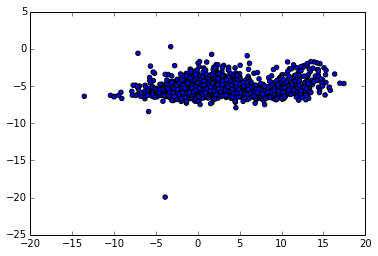

In [12]:
## create matrices for the outputs of the model
Y_translation    = df_full.reset_index()['translation'].astype('Float64')
Y_mrna_hl        = df_full.reset_index()['rna_hl'].astype('Float64')


plt.scatter(log2(Y_translation) ,log2(Y_mrna_hl) )
np.corrcoef(log2(Y_translation) ,log2(Y_mrna_hl) )

In [50]:
## Design matrix and vector of labels of the genes
X0               = df_full.reset_index().values[:,7:].astype('Float64')

## Scale the input variables and test that we don't have any NA's
X = scale(X0,0)

## Labels
features_labels  = df_full.columns[6:]
gene_labels      = df_full.reset_index()['gene_ID']

In [56]:
## Log transformations and reshape
N                   = X.shape[0] 
Y_translation_log   = np.log2(Y_translation).reset_index().values[:,1].astype('Float64').reshape(N,1)
Y_mrna_hl_log       = np.log2(Y_mrna_hl).reset_index().values[:,1].astype('Float64').reshape(N,1)

(0, 260)

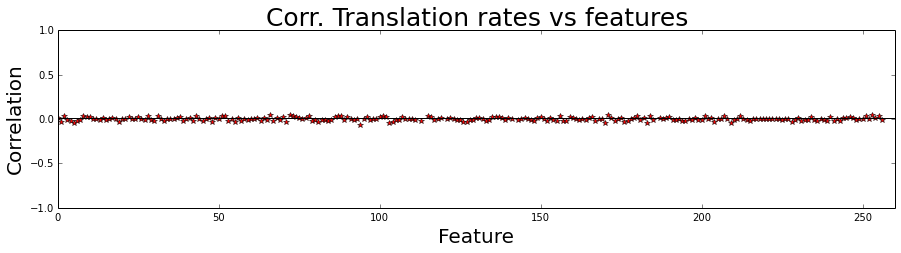

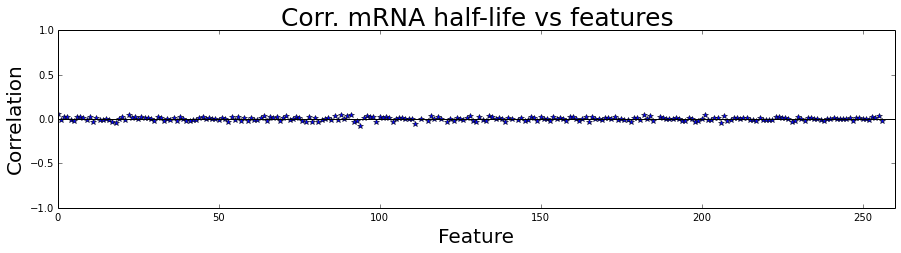

In [57]:
R_translation = np.corrcoef(np.hstack((Y_translation_log,X)).T)
R_stability  = np.corrcoef(np.hstack((Y_mrna_hl_log,X)).T)

# Plot of all the features
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.plot(R_translation[0,1:],'r*')
plt.xlabel('Feature',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.title('Corr. Translation rates vs features',fontsize=25)
plt.axhline(y=.01, xmin=0.0, linewidth=1, color = 'k')
plt.ylim(-1, 1)
plt.xlim(0,260)

# Plot of all the features
plt.figure(figsize=(15,7))
plt.subplot(212)
plt.plot(R_stability[0,1:],'b*')
plt.xlabel('Feature',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.title('Corr. mRNA half-life vs features',fontsize=25)
plt.axhline(y=.0, xmin=0.0, linewidth=1, color = 'k')
plt.ylim(-1, 1)
plt.xlim(0,260)

(0, 10000)

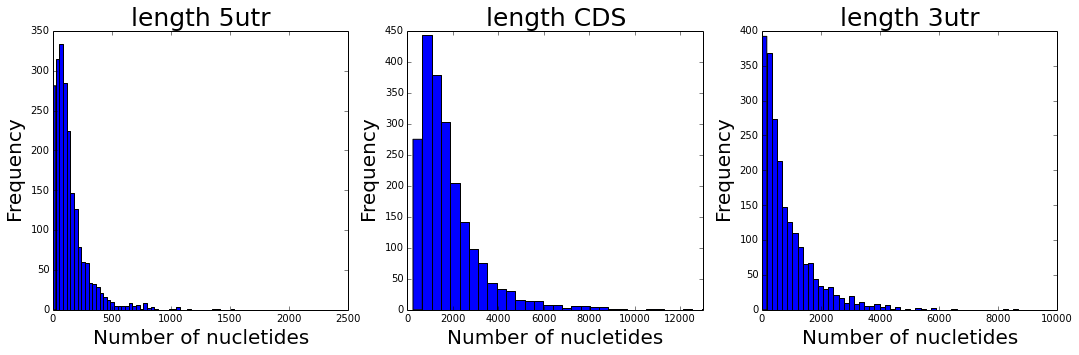

In [58]:
## First we have a look to some of the sequences

plt.figure(figsize=(18,5))
plt.subplot(131)
plt.hist(df_full['number_codons_5utr']*3,50)
plt.xlabel('Number of nucletides',fontsize=20)
plt.ylabel('Frequency ',fontsize=20)
plt.title('length 5utr',fontsize=25)
plt.xlim(0, 2500)

plt.subplot(132)
plt.hist(df_full['number_codons']*3,50)
plt.xlabel('Number of nucletides',fontsize=20)
plt.ylabel('Frequency ',fontsize=20)
plt.title('length CDS',fontsize=25)
plt.xlim(0, 13000)


plt.subplot(133)
plt.hist(df_full['number_codons_3utr']*3,50)
plt.xlabel('Number of nucletides',fontsize=20)
plt.ylabel('Frequency ',fontsize=20)
plt.title('length 3utr',fontsize=25)
plt.xlim(0, 10000)

(-1000, 0)

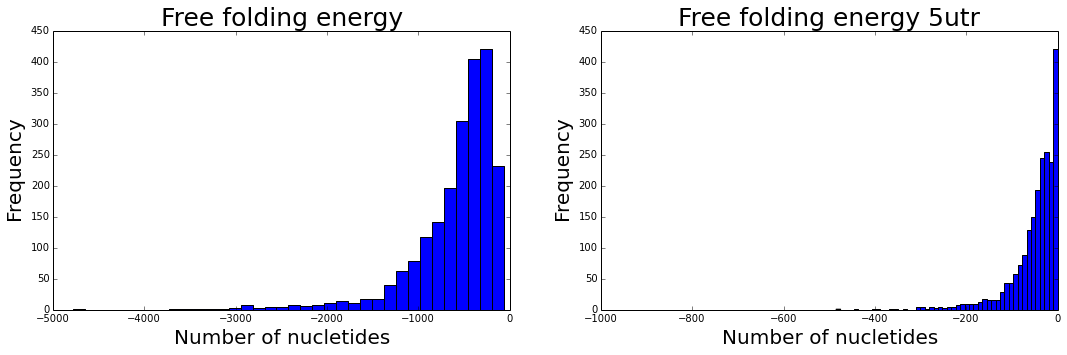

In [59]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.hist(df_full['free_energy'],50)
plt.xlabel('Number of nucletides',fontsize=20)
plt.ylabel('Frequency ',fontsize=20)
plt.title('Free folding energy ',fontsize=25)
plt.xlim(-5000, 0)

plt.subplot(122)
plt.hist(df_full['free_energy_5utr'],50)
plt.xlabel('Number of nucletides',fontsize=20)
plt.ylabel('Frequency ',fontsize=20)
plt.title('Free folding energy 5utr',fontsize=25)
plt.xlim(-1000, 0)

In [ ]:
## 4. Gaussian process model for the translational efficiency of mammalian cells

In [60]:
# Select training and test data
np.random.seed(123)
Ntrain = 1600
Ntest =  - Ntrain
myRange = range(N)
np.random.shuffle(myRange)

# Index of the training and test genes
sel_train = myRange[0:(Ntrain)]
sel_test  = myRange[Ntrain:N]

# Dimension of the input and ARD
input_dim = X.shape[1]

In [61]:
# kernels and model
Kbias   = GPy.kern.Bias(input_dim)
Klinear = GPy.kern.Linear(input_dim,ARD=1)
k     = Kbias + Klinear

# model
model_translation = GPy.models.GPRegression(X[sel_train,],Y_translation_log[sel_train,],kernel=k)
model_translation.Gaussian_noise.variance.constrain_bounded(0.01,100)

In [62]:
# model optimization
model_translation.optimize(optimizer='bfgs', max_iters=500, messages=1)
model_translation

GP_regression.,Value,Constraint,Prior,Tied to
add.bias.variance,4.77484864115,+ve,,
add.linear.variances,"(257,)",+ve,,
Gaussian_noise.variance,22.9372378201,"0.01,100.0",,


(0, 0.4)

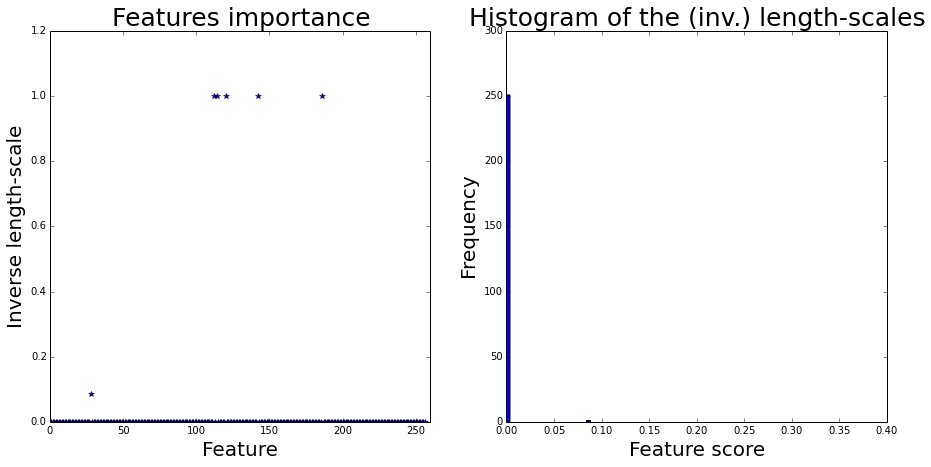

In [63]:
# Plot of all the features
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(model_translation.add.linear.variances,'b*')
plt.xlabel('Feature',fontsize=20)
plt.ylabel('Inverse length-scale',fontsize=20)
plt.title('Features importance',fontsize=25)
plt.xlim(0,260)

plt.subplot(122)
plt.hist(model_translation.add.linear.variances,bins=275)
plt.xlabel('Feature score',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title('Histogram of the (inv.) length-scales',fontsize=25)
plt.xlim(0,0.4)

In [64]:
# List of most influential features
idx = model_translation.add.linear.variances > 0.01
dd = {'weight': model_translation.add.linear.variances,
      'influence': model_translation.predictive_gradients(X[0:1,:])[0][0,:].reshape(1,input_dim)[0],
      'feature':features_labels}

selected_features_translation = DataFrame(dd) 

(0, 260)

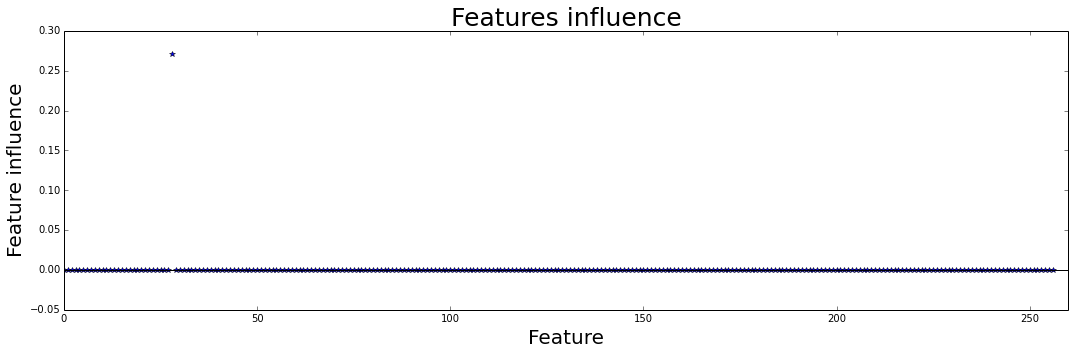

In [65]:
# Plot of all the features
plt.figure(figsize=(18,5))

plt.plot(selected_features_translation['influence'],'b*')
plt.xlabel('Feature',fontsize=20)
plt.ylabel('Feature influence',fontsize=20)
plt.title('Features influence',fontsize=25)
plt.axhline(y=.0, xmin=0.0, xmax=250, linewidth=1, color = 'k')
plt.xlim(0,260)

In [66]:
# features sorted by influence
selected_features_translation.sort(['influence'],ascending =0)

,feature,influence,weight
28,cta,2.712989e-01,8.641642e-02
206,Q,6.671627e-07,9.622452e-08
196,E,3.107807e-07,1.243629e-07
201,K,2.739878e-07,3.676017e-08
180,tca_rs,1.019309e-07,5.486265e-08
144,caa_rs,5.199689e-08,1.166814e-08
210,V,3.458582e-08,1.082614e-08
18,cag,2.872229e-08,4.509219e-09
130,aag_rs,1.059603e-08,5.297521e-09
145,cac_rs,1.032570e-08,1.574306e-09


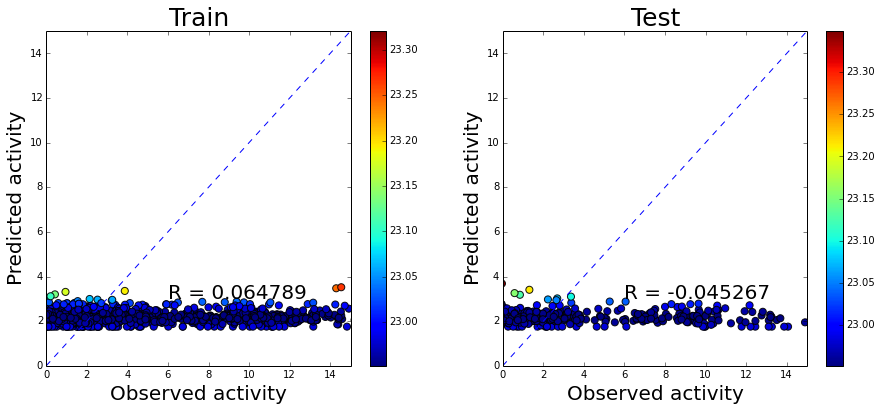

In [67]:
## prediction of the model in the training and test sets
prediction_train = model_translation.predict(X[sel_train,:])
prediction_test  = model_translation.predict(X[sel_test,:])

cor_train = cor(prediction_train[0],Y_translation_log[sel_train,])[0]
cor_test = cor(prediction_test[0],Y_translation_log[sel_test,])[0]

# Train data
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(Y_translation_log[sel_train,],prediction_train[0],c=prediction_train[1],s=50,alpha=25)
plt.xlabel('Observed activity',fontsize=20)
plt.ylabel('Predicted activity',fontsize=20)
plt.title('Train',fontsize=25)
plt.xlim(0, 15)
plt.ylim(0,  15)
plt.plot(np.linspace(0,16,100), np.linspace(0,16,100), 'b--')
plt.colorbar()
plt.text(6,3,'R = %2f' % cor_train,fontsize=20)


# Test data
plt.subplot(122)
plt.scatter(Y_translation_log[sel_test,],prediction_test[0],c=prediction_test[1],s=50,alpha=25)
plt.title('Test',fontsize=25)
plt.xlabel('Observed activity',fontsize=20)
plt.ylabel('Predicted activity',fontsize=20)
plt.colorbar()
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.plot(np.linspace(0,16,100), np.linspace(0,16,100), 'b--')
plt.text(6,3,'R = %2f' % cor_test,fontsize=20)